In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML, SVG
from graphviz import Source
import model_evaluation_utils as meu
import pkg_extractor
# from collections import Counter
import shap
import eli5
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

%matplotlib inline

shap.initjs()

In [2]:
data, labels = shap.datasets.adult(display=True)
labels = np.array([int(label) for label in labels])
data.shape, labels.shape

((32561, 12), (32561,))

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
Age               32561 non-null float32
Workclass         32561 non-null category
Education-Num     32561 non-null float32
Marital Status    32561 non-null category
Occupation        32561 non-null category
Relationship      32561 non-null category
Race              32561 non-null category
Sex               32561 non-null category
Capital Gain      32561 non-null float32
Capital Loss      32561 non-null float32
Hours per week    32561 non-null float32
Country           32561 non-null category
dtypes: category(7), float32(5)
memory usage: 862.2 KB


In [4]:
cat_cols = data.select_dtypes(include=['category']).columns
# data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)   # label encoding, alternatively:
for col in data[cat_cols]:
    data[col] = data[col].cat.codes
data.head()

Age  Workclass  Education-Num  Marital Status  Occupation  Relationship  \
0  39.0          7           13.0               4           1             1   
1  50.0          6           13.0               2           4             0   
2  38.0          4            9.0               0           6             1   
3  53.0          4            7.0               2           6             0   
4  28.0          4           13.0               2          10             5   

   Race  Sex  Capital Gain  Capital Loss  Hours per week  Country  
0     4    1        2174.0           0.0            40.0       39  
1     4    1           0.0           0.0            13.0       39  
2     4    1           0.0           0.0            40.0       39  
3     2    1           0.0           0.0            40.0       39  
4     2    0           0.0           0.0            40.0        5

In [5]:
# Counter(labels)   # ok, alternatively:
np.bincount(labels)

array([24720,  7841])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22792, 12), (9769, 12), (22792,), (9769,))

In [7]:
data_ORIG, labels_ORIG = shap.datasets.adult(display=True)
X_train_ORIG, X_test_ORIG, y_train_ORIG, y_test_ORIG = train_test_split(data, labels, test_size=0.3, random_state=42)

In [8]:
xgbc = xgboost.XGBClassifier(n_estimators=500, objective='binary:logistic', random_state=42)
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [9]:
y_Predicted = xgbc.predict(X_test)

meu.display_model_performance_metrics(y_test, y_Predicted)

Model Performance metrics:
------------------------------
Accuracy: 0.8742
Precision: 0.8697
Recall: 0.8742
F1 Score: 0.8701

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.78      0.65      0.71      2314
           0       0.90      0.94      0.92      7455

   micro avg       0.87      0.87      0.87      9769
   macro avg       0.84      0.80      0.82      9769
weighted avg       0.87      0.87      0.87      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       1510   804
        0        425  7030


# Feaure importances, based on XGBoost's Feature Weights, Gain and Coverage:

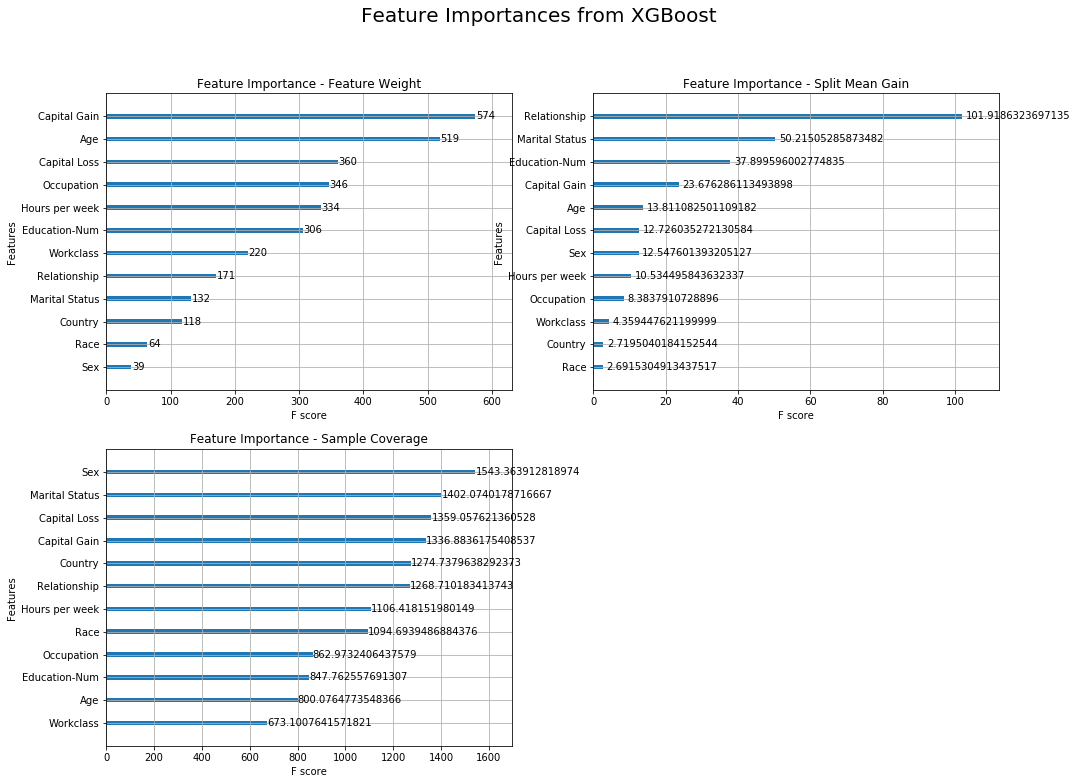

In [10]:
fig = plt.figure(figsize=(16, 12))
fig.suptitle("Feature Importances from XGBoost", fontsize=20)

ax1 = fig.add_subplot(2, 2, 1)
xgboost.plot_importance(xgbc, importance_type='weight', ax=ax1)
ax1.set_title('Feature Importance - Feature Weight')

ax2 = fig.add_subplot(2, 2, 2)
xgboost.plot_importance(xgbc, importance_type='gain', ax=ax2)
ax2.set_title('Feature Importance - Split Mean Gain')

ax3 = fig.add_subplot(2, 2, 3)
xgboost.plot_importance(xgbc, importance_type='cover', ax=ax3)
ax3.set_title('Feature Importance - Sample Coverage');

# Interpreting Random Forest with treeinterpreter

In [11]:
rfc = RandomForestClassifier(n_estimators=500, class_weight='balanced_subsample', n_jobs=-1, random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [12]:
rfc_Predicted = rfc.predict(X_test)

meu.display_model_performance_metrics(y_test, rfc_Predicted)

Model Performance metrics:
------------------------------
Accuracy: 0.8482
Precision: 0.8444
Recall: 0.8482
F1 Score: 0.8459

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.70      0.64      0.67      2314
           0       0.89      0.91      0.90      7455

   micro avg       0.85      0.85      0.85      9769
   macro avg       0.79      0.78      0.78      9769
weighted avg       0.84      0.85      0.85      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       1477   837
        0        646  6809


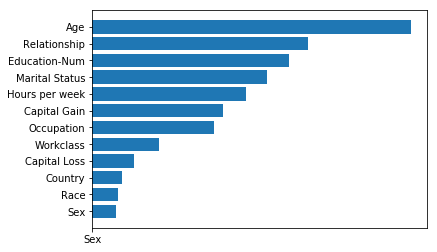

In [13]:
feats, importances = zip(*sorted(zip(X_test.columns, rfc.feature_importances_), key=lambda x: x[1]))
plt.xticks(range(len(feats)), feats)
plt.barh(feats, importances);

In [14]:
pred_10, bias, contribution = ti.predict(rfc, X_test[:10])

print(pred_10.shape, bias.shape, contribution.shape)
print(pred_10[0], bias[0])
contribution[0]

(10, 2) (10, 2) (10, 12, 2)
[0.998 0.002] [0.5 0.5]


array([[ 0.13028379, -0.13028379],
       [ 0.00120147, -0.00120147],
       [ 0.0473808 , -0.0473808 ],
       [ 0.0067732 , -0.0067732 ],
       [ 0.02278181, -0.02278181],
       [ 0.15886824, -0.15886824],
       [-0.00124049,  0.00124049],
       [ 0.03471392, -0.03471392],
       [ 0.0320944 , -0.0320944 ],
       [ 0.00456945, -0.00456945],
       [ 0.05961489, -0.05961489],
       [ 0.00095853, -0.00095853]])

In [15]:
# Accuracy:
(pred_10.argmax(axis=1) == y_test[:10]).mean()

0.9

In [16]:
for i in range(3):
    yi = y_test[i]
    p = pred_10[i].argmax()
    print("ACTUAL/PREDICTED CLASS:", yi, "/", p)
    for c, f in sorted(zip(contribution[i], X_test.columns), reverse=True, key=lambda x: abs(x[0][0])):
        cc = c.argmax()
        print(f, "contributed", c.max().round(3),  "to class", cc, "- Correct class?", yi==cc)
    print()

ACTUAL/PREDICTED CLASS: 0 / 0
Relationship contributed 0.159 to class 0 - Correct class? True
Age contributed 0.13 to class 0 - Correct class? True
Hours per week contributed 0.06 to class 0 - Correct class? True
Education-Num contributed 0.047 to class 0 - Correct class? True
Sex contributed 0.035 to class 0 - Correct class? True
Capital Gain contributed 0.032 to class 0 - Correct class? True
Occupation contributed 0.023 to class 0 - Correct class? True
Marital Status contributed 0.007 to class 0 - Correct class? True
Capital Loss contributed 0.005 to class 0 - Correct class? True
Race contributed 0.001 to class 1 - Correct class? False
Workclass contributed 0.001 to class 0 - Correct class? True
Country contributed 0.001 to class 0 - Correct class? True

ACTUAL/PREDICTED CLASS: 0 / 1
Marital Status contributed 0.179 to class 1 - Correct class? False
Workclass contributed 0.153 to class 0 - Correct class? True
Education-Num contributed 0.115 to class 0 - Correct class? True
Relationsh

# Model Explanation with Eli5

In [17]:
# Global prediction explanation, for XGBoost:
# same as xgboost.plot_importance(xgbc, importance_type='gain', ax=ax2):
eli5.show_weights(xgbc.get_booster())

In [18]:
# Local prediction explanation:
for i in range(3):
    yi = y_test[i]
    p = y_Predicted[i]
    print("ACTUAL/PREDICTED CLASS:", yi, "/", p)
    display(eli5.show_prediction(xgbc.get_booster(), X_test.iloc[i],
                               feature_names=list(data.columns), show_feature_values=True))
    print()

ACTUAL/PREDICTED CLASS: 0 / 0



ACTUAL/PREDICTED CLASS: 0 / 0



ACTUAL/PREDICTED CLASS: 1 / 1


In [19]:
# Global prediction explanation, for XGBoost:
# same as rfc.feature_importances_
eli5.show_weights(rfc, feature_names=list(data.columns))

In [20]:
# Local prediction explanation:
for i in range(3):
    yi = y_test[i]
    p = rfc_Predicted[i]
    print("ACTUAL/PREDICTED CLASS:", yi, "/", p)
    display(eli5.show_prediction(rfc, X_test.iloc[i], feature_names=list(data.columns), show_feature_values=True))
    print()

ACTUAL/PREDICTED CLASS: 0 / 0



ACTUAL/PREDICTED CLASS: 0 / 1



ACTUAL/PREDICTED CLASS: 1 / 1


# Model Explanation with Skater

In [21]:
interpreter = Interpretation(training_data=X_test, training_labels=y_test, feature_names=list(data.columns))
im_model = InMemoryModel(xgbc.predict_proba, examples=X_train, target_names=['under $50K', 'over $50K'])

2018-12-20 15:05:29,135 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progress_bar=False


[12/12] features ████████████████████ Time elapsed: 4 seconds

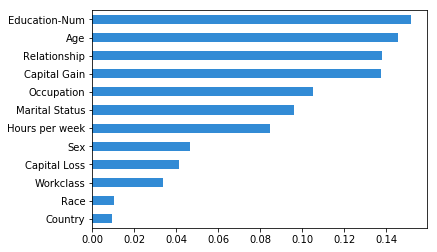

In [22]:
plots = interpreter.feature_importance.plot_feature_importance(im_model, ascending=True, n_samples=23000)

2018-12-20 15:05:48,987 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[16/16] grid cells ████████████████████ Time elapsed: 3 seconds

(0, 1)

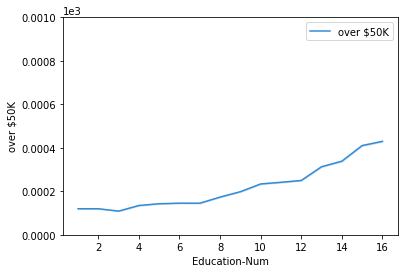

In [23]:
r = interpreter.partial_dependence.plot_partial_dependence(['Education-Num'], im_model, grid_resolution=50, figsize=(6, 4),
                                                           grid_range=(0, 1), n_samples=23000, with_variance=True)
r[0][1].set_ylim(0, 1)

2018-12-20 15:06:08,812 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[44/44] grid cells ████████████████████ Time elapsed: 10 seconds

(0, 1)

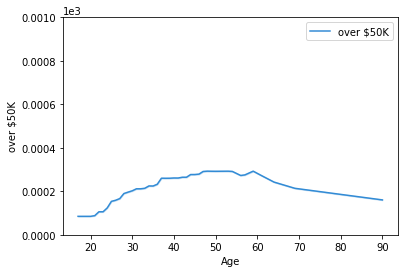

In [24]:
r = interpreter.partial_dependence.plot_partial_dependence(['Age'], im_model, grid_resolution=50, figsize=(6, 4),
                                                           grid_range=(0, 1), n_samples=23000, with_variance=True)
r[0][1].set_ylim(0, 1)

2018-12-20 15:06:34,750 - skater.core.explanations - WARNING - Progress bars slow down runs by 10-20%. For slightly 
faster runs, do progressbar=False


[1136/1136] grid cells ████████████████████ Time elapsed: 439 seconds

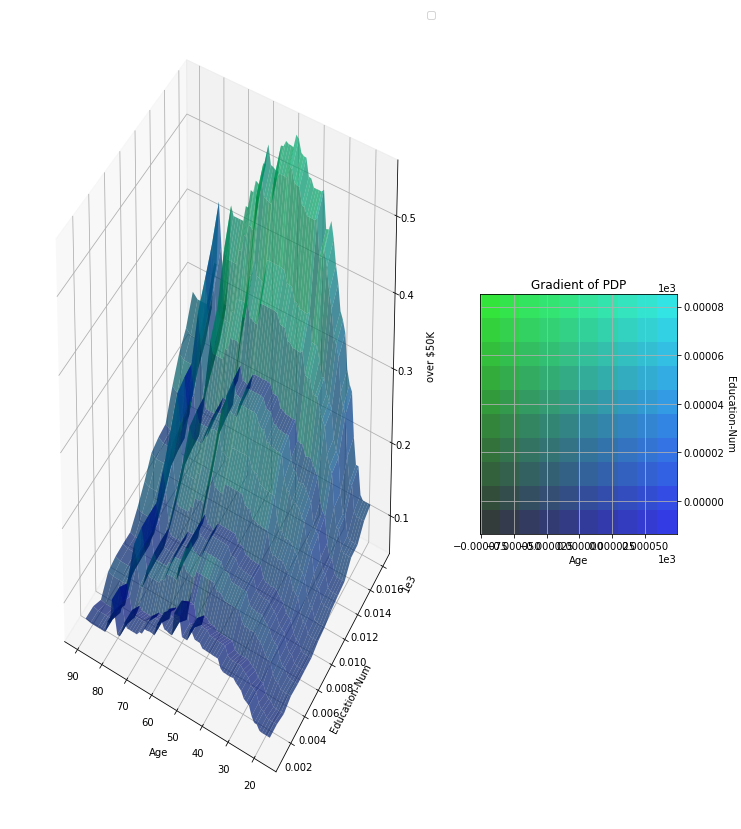

In [25]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('Age', 'Education-Num')], im_model,
                                                                    figsize=(12, 15), grid_range=(0, 1),
                                                                    grid_resolution=100, n_samples=23000)

In [26]:
# Skater's LIME for local explanation: 

explainer = LimeTabularExplainer(X_test.values, feature_names=list(data.columns), discretize_continuous=True,
                                 class_names=['<=$50K', '>$50K'])

In [27]:
# XGBoost has some issues with feature names in dataframes, build the same model with numpy arrays
xgbc_np = xgboost.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgbc_np.fit(X_train.values, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [28]:
# Local prediction explanation:
for i in range(3):
    yi = y_test[i]
    p = y_Predicted[i]
    print("ACTUAL/PREDICTED CLASS:", yi, "/", p)
    explainer.explain_instance(X_test.iloc[i].values, xgbc_np.predict_proba).show_in_notebook()
    print()

ACTUAL/PREDICTED CLASS: 0 / 0



ACTUAL/PREDICTED CLASS: 0 / 0



ACTUAL/PREDICTED CLASS: 1 / 1


In [29]:
surogate_explainer = interpreter.tree_surrogate(oracle=im_model, seed=42)
surogate_explainer.fit(X_train, y_train, use_oracle=True, prune='pre', scorer_type='f1')

2018-12-20 15:14:03,894 - skater.core.global_interpretation.tree_surrogate - INFO - pre pruning applied ...
2018-12-20 15:14:03,895 - skater.core.global_interpretation.tree_surrogate - INFO - Scorer used f1-score
2018-12-20 15:14:05,075 - skater.core.global_interpretation.tree_surrogate - INFO - Done generating prediction using the surrogate, shape (22792, 2)
2018-12-20 15:14:05,086 - skater.core.global_interpretation.tree_surrogate - INFO - Done scoring, surrogate score 0.911; oracle score 0.88


-0.031

In [30]:
sur_Predicted = surogate_explainer.predict(X_test)
meu.display_model_performance_metrics(y_test, sur_Predicted)

Model Performance metrics:
------------------------------
Accuracy: 0.8387
Precision: 0.8292
Recall: 0.8387
F1 Score: 0.8274

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           1       0.73      0.50      0.60      2314
           0       0.86      0.94      0.90      7455

   micro avg       0.84      0.84      0.84      9769
   macro avg       0.80      0.72      0.75      9769
weighted avg       0.83      0.84      0.83      9769


Prediction Confusion Matrix:
------------------------------
          Predicted:      
                   1     0
Actual: 1       1162  1152
        0        424  7031


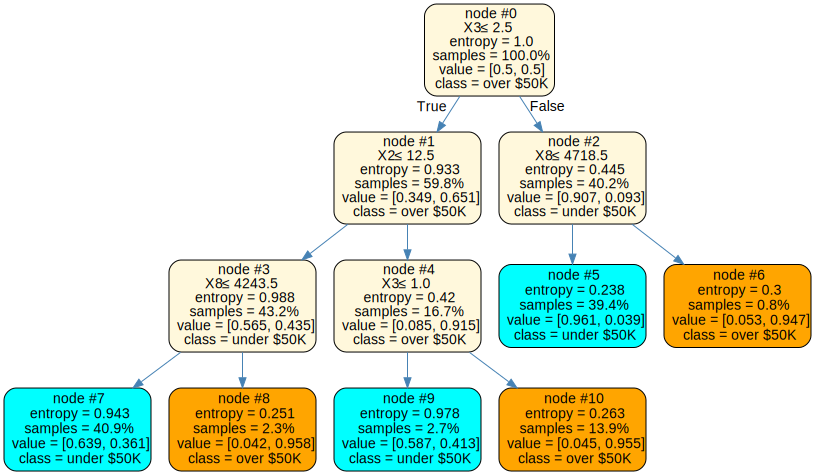

In [31]:
graph = Source(surogate_explainer.plot_global_decisions(colors=['cyan', 'orange'], file_name='tmp.png',
                                                       fig_size=(12, 8)).to_string())

svg_data = graph.pipe(format='svg')
with open('dtree_dtruture.svg', 'wb') as f:
    f.write(svg_data)
SVG(svg_data)

In [32]:
{'X'+str(idx): feature for (idx, feature) in enumerate(data.columns)}

{'X0': 'Age',
 'X1': 'Workclass',
 'X2': 'Education-Num',
 'X3': 'Marital Status',
 'X4': 'Occupation',
 'X5': 'Relationship',
 'X6': 'Race',
 'X7': 'Sex',
 'X8': 'Capital Gain',
 'X9': 'Capital Loss',
 'X10': 'Hours per week',
 'X11': 'Country'}

* If Marital Status >2.5 and Capital Gain $\le$4718.5 $\Rightarrow$ **96.1% chance of person earning $\le$\$50K**

* If Marital Status >2.5 and Capital Gain >4718.5 $\Rightarrow$ **94.7% chance of person earning >$50K**

* If Marital Status $\le$2.5 and Education-num $\le$12.5 and Capital Gain $\le$4243.5 $\Rightarrow$ **63.9% chance of person earning $\le$\$50K**

* If Marital Status $\le$2.5 and Education-num $\le$12.5 and Capital Gain >4243.5 $\Rightarrow$ **95.8% chance of person earing >$50K**

* If Marital Status $\le$1 and Education-num $\le$12.5 $\Rightarrow$ **58.7% chance of person earning $\le$\$50K**

* If 1 < Marital Status $\le$2.5 and Education-num $\le$12.5 $\Rightarrow$ **95.5% chance of person earing >$50K**

# Model Explaining with SHAP

In [33]:
explainer = shap.TreeExplainer(xgbc)
shap_values = explainer.shap_values(X_test)
pd.DataFrame(shap_values).head()

0         1         2         3         4         5         6   \
0 -0.901837  0.031459 -0.115094 -0.422054 -0.231562 -0.594173  0.004624   
1  0.303610 -0.280508 -0.408431  0.432996  0.371238  1.296284  0.019783   
2 -0.430618  0.036815  0.736322  0.309133  0.561346  0.594314 -0.151146   
3 -0.414673  0.037509  0.551267 -0.821778 -0.520878 -0.593187  0.027511   
4 -0.271268 -0.314924 -0.133764 -0.227522 -0.132181 -0.533217 -0.018377   

         7         8         9         10        11  
0 -0.587276 -0.130221 -0.050567 -0.501520  0.004776  
1 -0.245622 -0.121686 -0.059354 -0.084898  0.016151  
2  0.066327 -0.165892 -0.072489  0.499625  0.022895  
3 -0.459894 -0.138487 -0.059705 -0.162662  0.019091  
4  0.090426 -2.878613 -0.054248  0.615626  0.008123

In [34]:
explainer.expected_value

-1.3132651

In [35]:
shap_values.sum(axis=1)[:5]

array([-3.4934466,  1.2395622,  2.0066319, -2.5358849, -3.8499393],
      dtype=float32)

In [54]:
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_ORIG.iloc[0,:])  # ok for individual samples
# For loop over several cases one needs display()
for i in range(3):
    display(shap.force_plot(explainer.expected_value, shap_values[i,:], X_test_ORIG.iloc[i,:]))

In [55]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test_ORIG.iloc[:1000,:])

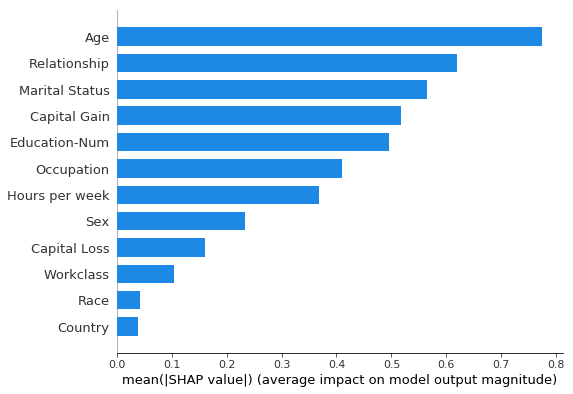

In [56]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

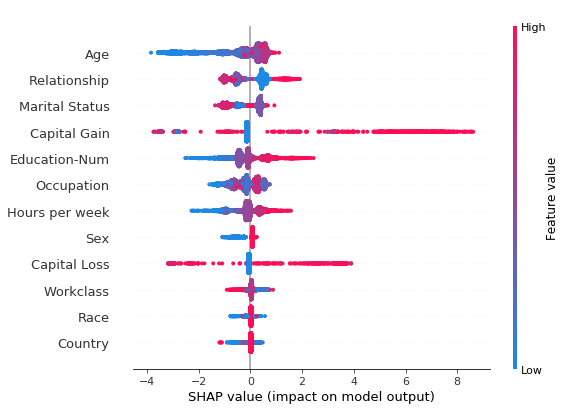

In [57]:
shap.summary_plot(shap_values, X_test)

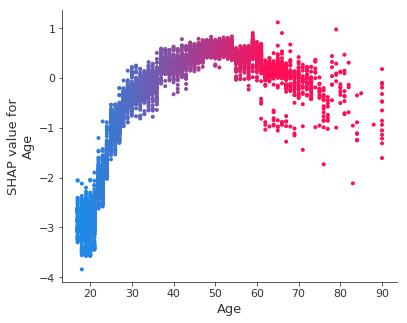

In [58]:
shap.dependence_plot(ind='Age', interaction_index='Age', shap_values=shap_values,
                     features=X_test, display_features=X_test_ORIG)

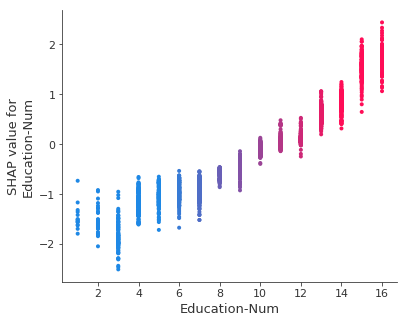

In [59]:
shap.dependence_plot(ind='Education-Num', interaction_index='Education-Num', shap_values=shap_values,
                     features=X_test, display_features=X_test_ORIG)

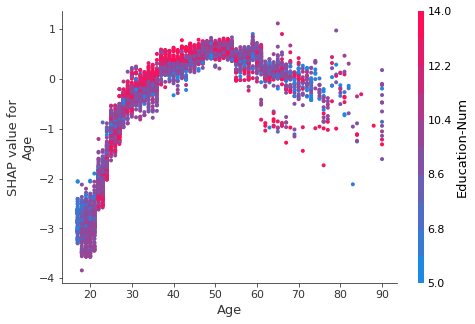

In [60]:
shap.dependence_plot(ind='Age', interaction_index='Education-Num', shap_values=shap_values,
                     features=X_test, display_features=X_test_ORIG)

In [51]:
%run -i pkg_extractor